In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
import seaborn as sns
%matplotlib inline

In [7]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


def gaussian(x, mu=0, sig=1):
    return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sig, 2.0)))


def bayesian_model(
    params,
    x_true,
    prior_probability,
    decision_boundary,
    prior_modulated_likelihood=False,
    likelihood_constant=10,
):
    """
    gamma: the side biases of the bird
    sigma: sigma of the likelihood gaussian
    delta: the overall innattentivity to cue stimuli
    alpha: the overall innattentivity all stimuli
    beta: the overall innattentivity to the categorical stimuli
    Parameters
    ----------
    params : [type]
        [description]
    x_true : [type]
        [description]
    prior_probability : [type]
        [description]
    decision_boundary : [type]
        [description]

    Returns
    -------
    [type]
        [description]
    """
    side_bias = (decision_boundary * (1 - ((1 - params["gamma_side_bias"]) * 2))) + (
        1 - params["gamma_side_bias"]
    )
    side_bias = side_bias / np.sum(side_bias)  # normalize the side bias

    # the likelihood is list of gaussians centered around x_true (the interpolation point)
    # .  at for each value of x_true

    # modulate likelihood based on prior
    if prior_modulated_likelihood:
        likelihoods = [
            params["sigma_likelihood"]
            * (-np.log(prior_probability[i]))
            / likelihood_constant
            for i, x_i in enumerate(x_true)
        ]
        likelihood = np.array(
            [
                gaussian(x_true, x_i, l)
                for i, (x_i, l) in enumerate(zip(x_true, likelihoods))
            ]
        )
    else:
        likelihood = np.array(
            [gaussian(x_true, x_i, params["sigma_likelihood"]) for x_i in x_true]
        )
    likelihood = np.array(
        [i / np.sum(i) for i in likelihood]
    )  # normalize likelihood gaussian to sum to 1

    likelihood = np.array(
        [
            (1 - params["beta_categorical_attention"]) * i
            + params["beta_categorical_attention"] * side_bias
            for i in likelihood
        ]
    )
    likelihood = np.array(
        [i / np.sum(i) for i in likelihood]
    )  # normalize full likelihood to sum to 1

    # calculate the bias of the prior probability
    prior_probability = (
        1.0 - params["delta_cue_attention"]
    ) * prior_probability + side_bias * params["delta_cue_attention"]

    # calculate the posterior probability
    posterior_probability = likelihood * prior_probability
    posterior_probability = np.array(
        [i / np.sum(i) for i in posterior_probability]
    )  # normalize posterior probability to sum to 1
    # posterior_probability = params['alpha']*posterior_probability+((1.-params['alpha'])*params['gamma'])
    posterior_probability = (
        1.0 - params["alpha_overall_attention"]
    ) * posterior_probability + ((params["alpha_overall_attention"]) * side_bias)
    posterior_probability = np.array(
        [i / np.sum(i) for i in posterior_probability]
    )  # normalize posterior probability to sum to 1

    # make a decision
    decision = np.sum([i * decision_boundary for i in posterior_probability], axis=1)

    likelihood_similarity = cosine_similarity(likelihood)
    posterior_similarity = cosine_similarity(posterior_probability)

    return (
        decision,
        posterior_probability,
        likelihood,
        likelihood_similarity,
        posterior_similarity,
    )

In [8]:
def quick_sketch_integration(
    prior_probability,
    decision,
    posterior_probability,
    likelihood,
    likelihood_similarity,
    posterior_similarity,
    x_true, 
    x_true_bds,
    x_stack
):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
    ax = axs.flatten()[0]
    ax.set_title("Prior")
    ax.plot(x_true[bds[0] : bds[1]], prior_probability[bds[0] : bds[1]])

    ax = axs.flatten()[1]
    ax.set_title("Likelihood")
    ax.matshow(likelihood[bds[0] : bds[1], bds[0] : bds[1]], aspect="auto")

    ax = axs.flatten()[2]
    ax.set_title("posterior")
    ax.matshow(posterior_probability[bds[0] : bds[1], bds[0] : bds[1]], aspect="auto")

    ax = axs.flatten()[3]
    ax.set_title("Actual vs perceived stimulus")
    subsamp = 5
    for i in x_stack[::subsamp]:
        ax.plot(i, [1, 0], color="k")
    ax.set_xlim([x_true_bds[0], x_true_bds[1]])
    # axs[0].axis('off')

    ax = axs.flatten()[4]
    ax.set_title("Similarity of likelihood")
    ax.matshow(likelihood_similarity[bds[0] : bds[1], bds[0] : bds[1]], aspect="auto")

    ax = axs.flatten()[5]
    ax.set_title("Similarity of posterior")
    ax.matshow(posterior_similarity[bds[0] : bds[1], bds[0] : bds[1]], aspect="auto")

    ax = axs.flatten()[6]
    ax.set_title("Decision")
    ax.plot(x_true[bds[0] : bds[1]], decision[bds[0] : bds[1]])

    ax = axs.flatten()[7]
    ax.set_title("Likelihood")
    for i in likelihood[bds[0] : bds[1]][::20]:
        ax.plot(x_true, i, color="k", lw=3)
    ax.set_xlim([x_true_bds[0], x_true_bds[1]])

    ax = axs.flatten()[8]
    ax.set_title("Posterior")
    for i in posterior_probability[bds[0] : bds[1]][::20]:
        ax.plot(x_true, i, color="k", lw=3)
    ax.set_xlim([x_true_bds[0], x_true_bds[1]])
    plt.tight_layout()

### default single prior distribution

In [36]:
params = {
    'sigma_likelihood':20, # std of gaussian for likelihood
    'beta_categorical_attention': 0, # pct of time ignoring the categorical stimulus # if set at 0 all guesses are based upon the cue, 
    'delta_cue_attention':0, # pct of time ignoring the cue
    'alpha_overall_attention':0, # pct of time ingoring both the cue, and categorical stimulis, independant of the product of beta and delta 
    'gamma_side_bias': .5 # the direction of the random guess (side bias)
}

In [64]:
x_true = np.arange(-200, 200)
half = int(len(x_true)/2)
decision_boundary = np.concatenate([np.zeros(half), np.ones(half)])
bds = [half-64, half+64]
x_true_bds = [x_true[half]-64, x_true[half]+64]
unimodal_prior = True
if unimodal_prior:
    prior_probability = gaussian(x_true, np.mean(x_true), 20)
    prior_probability = prior_probability/np.sum(prior_probability)
else:
    prior_probability1 = gaussian(x_true, np.mean(x_true)-50, 20)
    prior_probability2 = gaussian(x_true, np.mean(x_true)+50, 20)
    prior_probability = prior_probability1 + prior_probability2
    prior_probability = prior_probability/np.sum(prior_probability)

(-64.0, 64.0, -0.04998437744115196, 1.0496719262641911)

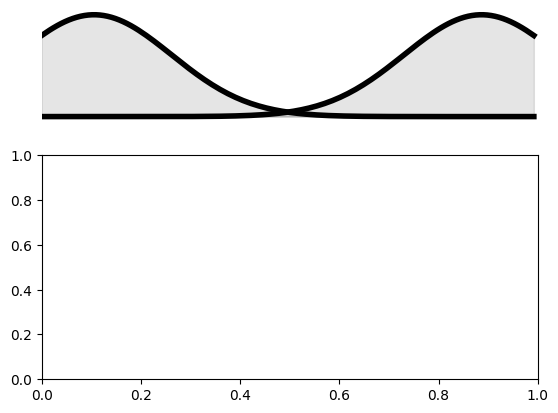

In [69]:
fig, axs = plt.subplots(nrows=2, gridspec_kw={"height_ratios": [1, 2]})
ax = axs[0]
ax.plot(x_true[bds[0] : bds[1]], prior_probability1[bds[0] : bds[1]], color="k", lw=4)

ax.fill_between(
    x_true[bds[0] : bds[1]],
    np.zeros(len(prior_probability1[bds[0] : bds[1]])),
    prior_probability1[bds[0] : bds[1]],
    color="k",
    alpha=0.1,
)

ax.plot(x_true[bds[0] : bds[1]], prior_probability2[bds[0] : bds[1]], color="k", lw=4)

ax.fill_between(
    x_true[bds[0] : bds[1]],
    np.zeros(len(prior_probability2[bds[0] : bds[1]])),
    prior_probability2[bds[0] : bds[1]],
    color="k",
    alpha=0.1,
)

ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis("off")

In [70]:
decision, posterior_probability, likelihood, likelihood_similarity, posterior_similarity = bayesian_model(
    params, x_true, prior_probability, decision_boundary
)
x_shift = [np.mean(i*x_true)*len(x_true) for i in posterior_probability]
x_stack = np.stack([x_true, x_shift]).T

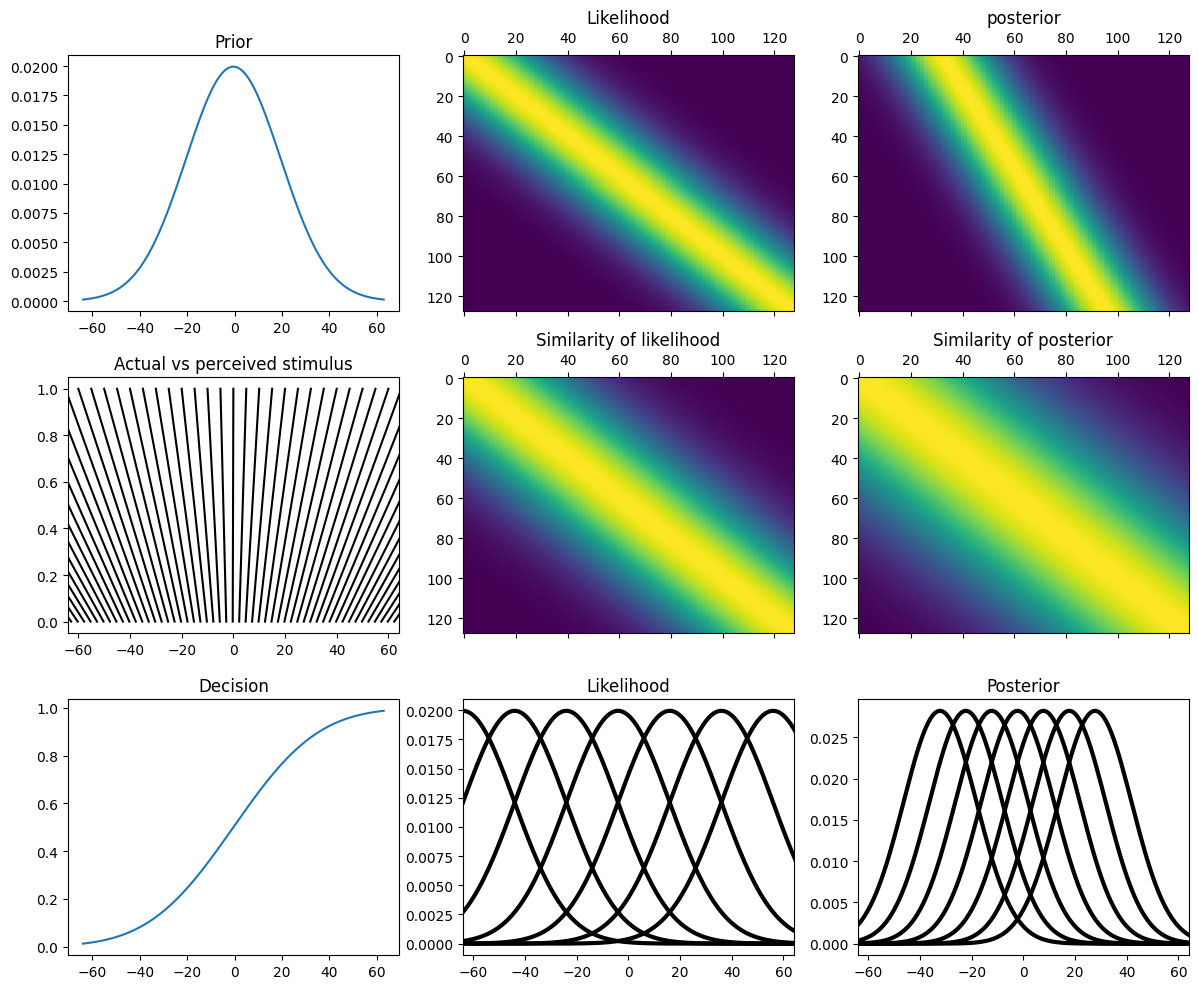

In [71]:
quick_sketch_integration(
    prior_probability,
    decision,
    posterior_probability,
    likelihood,
    likelihood_similarity,
    posterior_similarity,
    x_true,
    x_true_bds,
    x_stack,
)

(-64.0, 64.0, -0.05, 1.05)

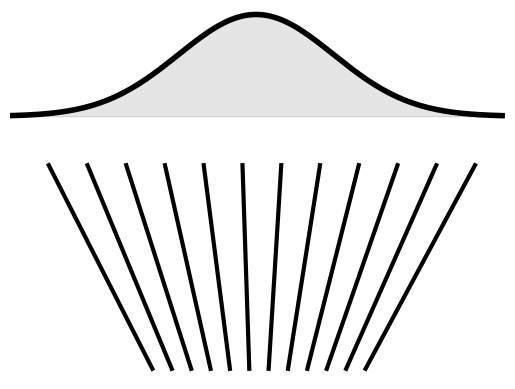

In [72]:
fig, axs = plt.subplots(nrows=2, gridspec_kw={"height_ratios": [1, 2]})
ax = axs[0]
ax.plot(x_true[bds[0] : bds[1]], prior_probability[bds[0] : bds[1]], color="k", lw=4)

ax.fill_between(
    x_true[bds[0] : bds[1]],
    np.zeros(len(prior_probability[bds[0] : bds[1]])),
    prior_probability[bds[0] : bds[1]],
    color="k",
    alpha=0.1,
)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis("off")

ax = axs[1]
subsamp = 10
ls = x_stack[bds[0] : bds[1]][::subsamp]
m = (ls[:, 0] > x_true_bds[0]) & (ls[:, 0] < x_true_bds[1])
ls = ls[m]
pal = sns.color_palette("viridis", len(ls))
for i, si in enumerate(ls):
    if (si[0] < x_true_bds[0]) or (si[0] > x_true_bds[1]):
        continue
    ax.plot(si, [1, 0], color="k", lw=3)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis("off")

(-64.0, 64.0, -0.0014102535895310646, 0.029615325380152352)

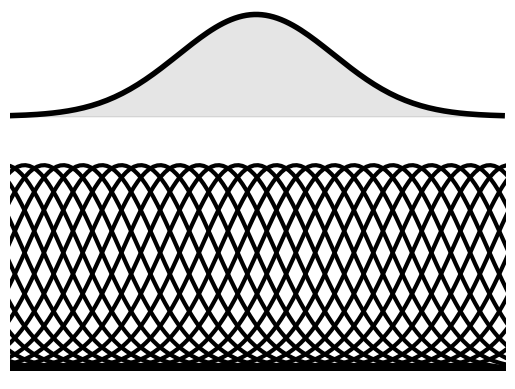

In [73]:
fig, axs = plt.subplots(nrows=2, gridspec_kw={"height_ratios": [1, 2]})

ax = axs[0]
ax.plot(x_true[bds[0] : bds[1]], prior_probability[bds[0] : bds[1]], color="k", lw=4)
ax.fill_between(
    x_true[bds[0] : bds[1]],
    np.zeros(len(prior_probability[bds[0] : bds[1]])),
    prior_probability[bds[0] : bds[1]],
    color="k",
    alpha=0.1,
)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis("off")

ax = axs[1]
subsamp = 10
#ls = posterior_probability[bds[0] : bds[1]][::subsamp]
ls = posterior_probability[::subsamp]
pal = sns.color_palette("viridis", len(ls))
for i, lsi in enumerate(ls):
    ax.plot(x_true, lsi, lw=3, color="k")
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis("off")

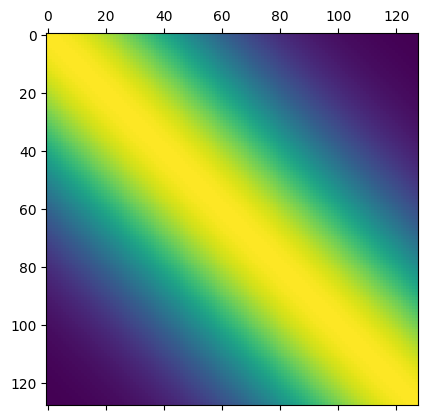

In [74]:
plt.matshow(posterior_similarity[bds[0] : bds[1], bds[0] : bds[1]])

### Modulate likelihood

In [75]:
prior_probability = prior_probability/np.sum(prior_probability)
decision, posterior_probability, likelihood, likelihood_similarity, posterior_similarity = bayesian_model(
    params, x_true, prior_probability, decision_boundary, prior_modulated_likelihood=True
)
x_shift = [np.mean(i*x_true)*len(x_true) for i in posterior_probability]
x_stack = np.stack([x_true, x_shift]).T

(-64.0, 64.0, -0.0025378115456326754, 0.05329404245828619)

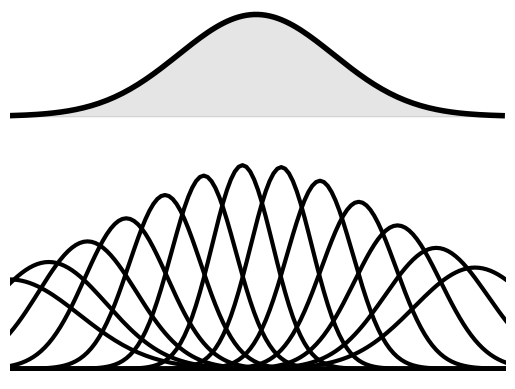

In [76]:
fig, axs = plt.subplots(nrows=2, gridspec_kw={"height_ratios": [1, 2]})

ax = axs[0]
ax.plot(x_true[bds[0] : bds[1]], prior_probability[bds[0] : bds[1]], color="k", lw=4)
ax.fill_between(
    x_true[bds[0] : bds[1]],
    np.zeros(len(prior_probability[bds[0] : bds[1]])),
    prior_probability[bds[0] : bds[1]],
    color="k",
    alpha=0.1,
)
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis("off")

ax = axs[1]
subsamp = 10
ls = likelihood[bds[0] : bds[1]][::subsamp]
pal = sns.color_palette("viridis", len(ls))
for i, lsi in enumerate(ls):
    ax.plot(x_true, lsi, lw=3, color="k")
ax.set_xlim([x_true_bds[0], x_true_bds[1]])
ax.axis("off")

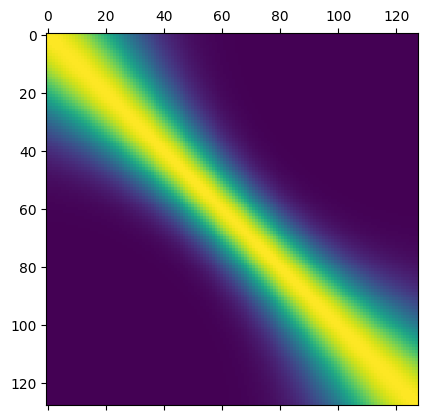

In [77]:
plt.matshow(likelihood_similarity[bds[0] : bds[1], bds[0] : bds[1]])